In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

### Steps to calculate self-attention:

1. Tokenize your data and get token embeddings (trained or pre-trained)
2. For each sentence:
    1. Calculate scaled dot-product between all combinations of token embeddings. If there are N tokens, number of combinations are N * N.
    2. Apply softmax to scaled dot-product to normalize it and treat it as weights.
    3. Multiply weights with embeddings to incorporate contextual information.
    4. Now you have contextual word embeddings for each sentence.

### GloVe Embeddings

In order to get embeddings, we can either train them or use pre-trained word embeddings. Training embeddings requires enormous amount of data that can truly capture semantic and syntactic relationships of a langugage as well as enormous compute resources, and so we will use pre-trained GLoVe embeddings. These embeddings are of different lengths - 50, 100, 200 and 300 where length can be treated as a hyperparameter. 

Although, longer embeddings can capture more information but have more computational complexity, this doesn't mean longer embeddings will always result in better results. Basically, this hyperparameter isn't interpretable and we will try to calculate self-attention for different embedding sizes.

In [2]:
# # download pre-trained GLoVe embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# # unzip file
# !unzip -q glove.6B.zip

In [3]:
# function for getting pre-trained embeddings
def get_embeddings(embedding_size):
    # read file
    with open(f'glove.6B.{embedding_size}d.txt') as f:
        data = f.read().splitlines()

    # store embeddings in dictionary
    embedding_dict = {}
    for line in tqdm(data):
        line = line.split()
        word = line[0]
        embedding = list(map(float, line[1:]))
        embedding_dict[word] = embedding

    return embedding_dict

# function for getting tokens of input sentence
def get_tokens(SENTENCE):
    words = SENTENCE.split(' ')
    words = list(map(lambda x: x.lower(), words))
    tokens = list(set(words))
    return tokens

# function for applying softmax on matrix
def apply_softmax(A):
    return np.exp(A) / np.sum(np.exp(A), axis=1)        

In [4]:
def run(SENTENCE, EMBEDDING_SIZE):

    # get tokens for sentence
    tokens = get_tokens(SENTENCE)
    n_tokens = len(tokens)

    # get GLoVe embeddings 
    embedding_dict = get_embeddings(EMBEDDING_SIZE)

    # get embeddings for out tokens
    embeddings = np.array([embedding_dict[token] for token in tokens])

    # calculate scaled dot product for all combinations of embeddings
    dot_product_matrix = np.dot(embeddings, np.transpose(embeddings))
    scaled_dot_product_matrix = dot_product_matrix / max(np.max(dot_product_matrix), 1)

    # since there are N * N combinations
    # shape of matrix should be (N, N) where N is number of tokens
    # also matrix is symmetric
    assert scaled_dot_product_matrix.shape == (n_tokens, n_tokens)
    assert np.allclose(scaled_dot_product_matrix, np.transpose(scaled_dot_product_matrix))
    
    # applying softmax to get weights summing to 1
    softmax_matrix = apply_softmax(scaled_dot_product_matrix)

    # plotting weights (highlighting attention)
    sns.heatmap(softmax_matrix, annot=True, xticklabels=tokens, yticklabels=tokens)
    
    # weighting embeddings according to softmax weights
    # now you have contextual embeddings
    weighted_embeddings = np.dot(softmax_matrix, embeddings)
    assert weighted_embeddings.shape == (n_tokens, EMBEDDING_SIZE)    
    return plt, weighted_embeddings

100%|██████████| 400000/400000 [00:10<00:00, 39948.26it/s]


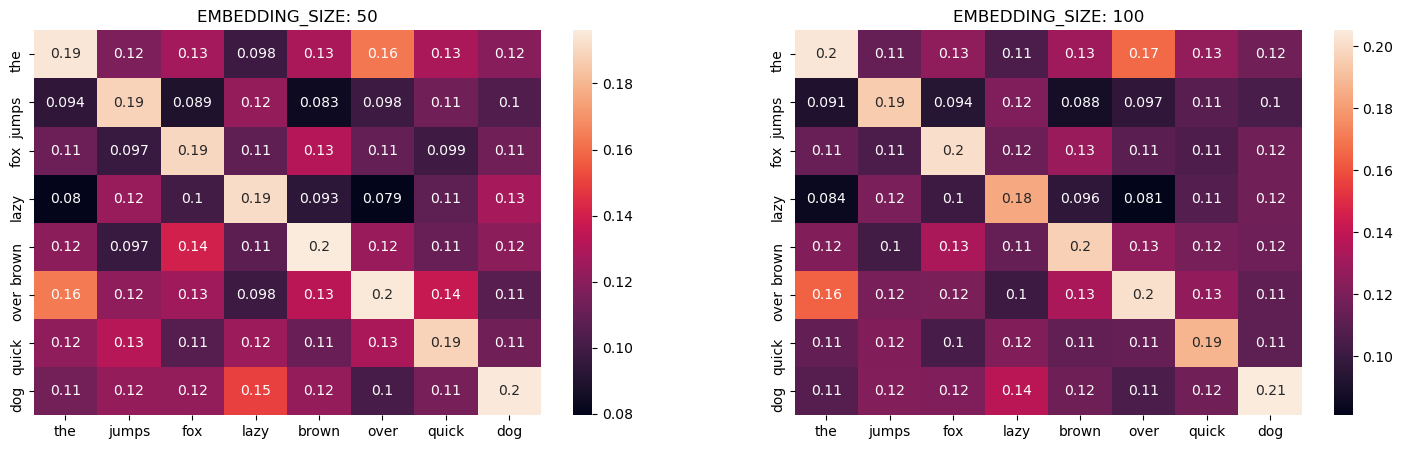

100%|██████████| 400000/400000 [00:25<00:00, 15606.85it/s]


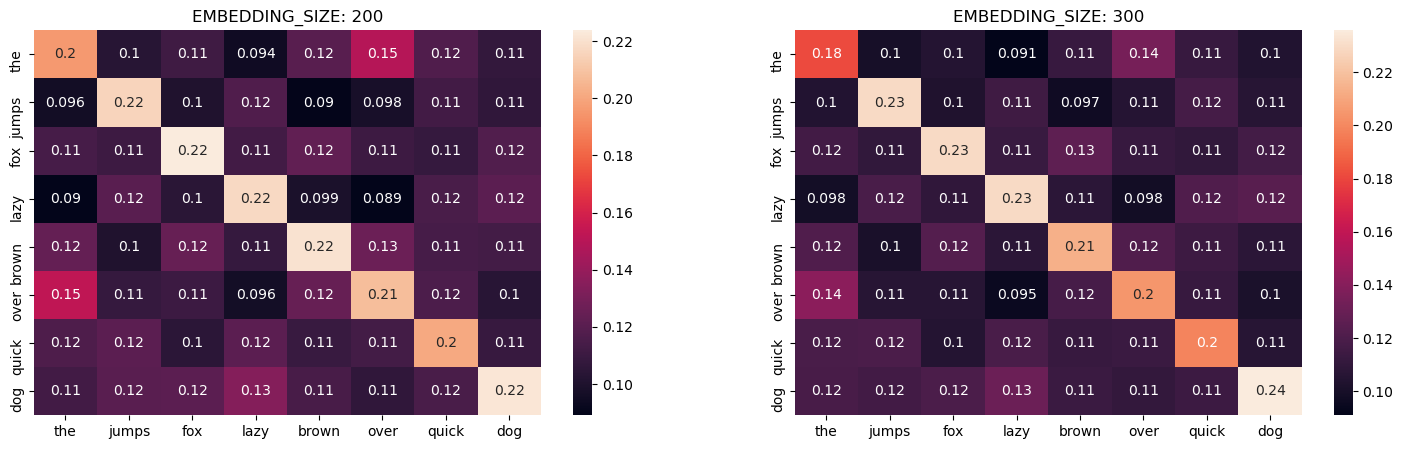

In [5]:
SENTENCE = 'The quick brown fox jumps over the lazy dog'

plt.figure(figsize=(18,5))
plt.subplot(121)
EMBEDDING_SIZE = 50
plt, weighted_embeddings = run(SENTENCE, EMBEDDING_SIZE)
plt.title(f'EMBEDDING_SIZE: {EMBEDDING_SIZE}')

plt.subplot(122)
EMBEDDING_SIZE = 100
plt, weighted_embeddings = run(SENTENCE, EMBEDDING_SIZE)
plt.title(f'EMBEDDING_SIZE: {EMBEDDING_SIZE}')
plt.show()

plt.figure(figsize=(18,5))
plt.subplot(121)
EMBEDDING_SIZE = 200
plt, weighted_embeddings = run(SENTENCE, EMBEDDING_SIZE)
plt.title(f'EMBEDDING_SIZE: {EMBEDDING_SIZE}')

plt.subplot(122)
EMBEDDING_SIZE = 300
plt, weighted_embeddings = run(SENTENCE, EMBEDDING_SIZE)
plt.title(f'EMBEDDING_SIZE: {EMBEDDING_SIZE}')
plt.show()

### Final Notes:

1. Scaled Dot Product Matrix is symmetric which is because dot product is commutative i.e. D(A, B) = D(B, A)
2. After applying Softmax, the matrix no longer remains symmetric
3. For the input sentence, following pairs exhibit relatively higher correlation:
    1. (the, over)
    2. (brown, fox)
    3. (lazy, dog)
